In [13]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize

In [3]:
# загружаем данные
df_train = pd.read_csv('train.csv', sep='\t')
df_test = pd.read_csv('test.csv', sep='\t')

In [5]:
# объединяем в один датафрейм, чтбы удобнее было
df_test['target'] = 'NaN'
df_train['train'] = 1
df_test['train'] = 0

df = df_train.append(df_test)

# таргет делаем числовым
df['target'] = pd.to_numeric(df['target'], errors='coerce')

In [6]:
# функция для удаления html-размекти
def remove_html_tags(text):
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', text)

In [7]:
# чистим html-разметку
for c in ['description', 'name']:
    df[c] = df[c].apply(remove_html_tags)

# наверно неважно, находится слово в названии или описании, объединим их в одно текстовое поле
df.loc[:, 'text'] = df.loc[:,'name'] + df.loc[:, 'description']

In [11]:
# TF-IDF наверняка будет достаточно, уберем русские стоп-слова, и оставим только N=10000 самых значиымх слов из корпуса в качестве фич
tfidf_vect = TfidfVectorizer(stop_words=stopwords.words('russian'), max_features=10000)
tfidf_vect.fit(df['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', '...гда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
# преобразуем все тексты в фичи
tfidf_matrix = tfidf_vect.transform(df[df['train'] == 1]['text'])

In [14]:
# обучающая выборка
X = tfidf_matrix
y = df[df['train'] == 1]['target']

In [16]:
print(X.shape)
print(y.shape)

(200000, 10000)
(200000,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [20]:
# посмотрим какой классфикатор будет лучше работать

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

clrs = {
    'DecisionTreeClassifier':DecisionTreeClassifier,
    'RandomForestClassifier':RandomForestClassifier,
#    'KNeighborsClassifier':KNeighborsClassifier,
    'LogisticRegression':LogisticRegression
}

y_pred = {}
y_pred_proba = {}

for clr_name in clrs.keys():
    clr_instance = clrs[clr_name]()
    clr_instance.fit(X_train, y_train)
    y_pred[clr_name] = clr_instance.predict(X_test)
    y_pred_proba[clr_name] = clr_instance.predict_proba(X_test)

In [21]:
# а метрики то ничего так вышли

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {}

for clr_name in clrs.keys():
    
    metrics[clr_name] = [accuracy_score(y_test, y_pred[clr_name]),
                         precision_score(y_test, y_pred[clr_name]),
                         recall_score(y_test, y_pred[clr_name]),
                         f1_score(y_test, y_pred[clr_name])
                        ]
    
    print('{} metrics: '.format(clr_name), metrics[clr_name])

DecisionTreeClassifier metrics:  [0.941075, 0.9375033672754701, 0.9356382406710398, 0.9365698754003069]
RandomForestClassifier metrics:  [0.957725, 0.9530035903756497, 0.9562318528874072, 0.9546149923508414]
LogisticRegression metrics:  [0.9606, 0.9503174603174603, 0.9657490052693838, 0.9579710917915623]


(-0.01, 1.01)

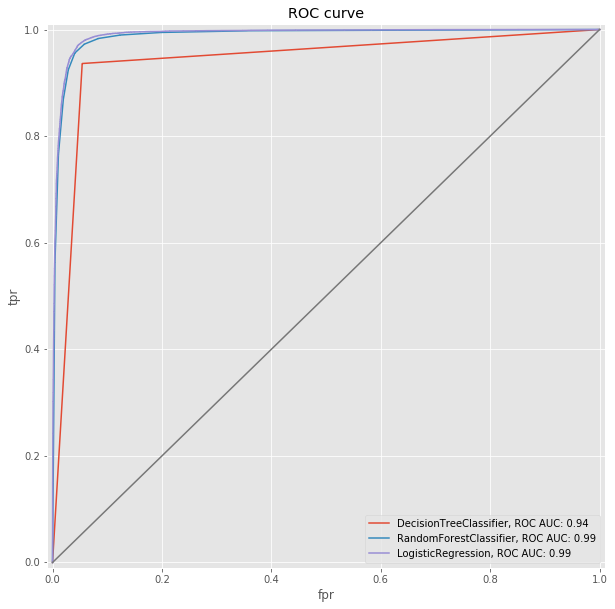

In [22]:
# и roc-auc неплохая
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

roc_curve_data = {}

for clr_name in clrs.keys():
    
    roc_curve_data[clr_name] = roc_curve(y_test, y_pred_proba[clr_name][:,1])
    
#print(roc_curve_data)
plt.figure(figsize=(10, 10))

for clr_name in clrs.keys():
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[clr_name][:,1])
    auc = roc_auc_score(y_test, y_pred_proba[clr_name][:,1])
    
    plt.plot(fpr, tpr, label='{}, ROC AUC: {:.2f}'.format(clr_name, auc))
    
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.legend()
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [23]:
# преобразуем тексты из проверочного множества в фичи

tfidf_matrix_validate = tfidf_vect.transform(df[df['train'] == 0]['text'])

In [24]:
X_ = tfidf_matrix_validate

X_.shape

(170179, 10000)

In [26]:
# логичстическая регрессия выше показала себя лучше всех, её используем для генерации submission
clr = LogisticRegression()
clr.fit(X, y)
y_hat = clr.predict(X_)
y_hat_proba = clr.predict_proba(X_)

# получили на сабмите 0.96269, можно и успокоиться

In [38]:
with open('submission.csv', 'w') as s:
    s.write('id,target\n')
    
    for id_, target in zip(df_test['id'].values, y_hat):
        s.write('{},{:.0n}\n'.format(id_, target))
        
s.close()

Что можно было бы улучшить?
1. Использовать стеммер для уменьшения размерности матрицы фичей
1. Обучить Vectorizer на данных из other.csv
1. Наверно 10 000 слов - слишком много, можно без потери качества обойтись и меньшим количеством слов, за счет этого ускорить обучение классификатора и
1. Подобрать гиперпараметры классификатора, например, через GridSearch
1. Использовать модели из statsmodels
1. Использовать векторное представление слов из word2vec, а тексты представлять как среднее от всех векторов слов в тексте
1. Использованить нейросетевые модели вместо всего этого